In [2]:
import nltk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gensim

In [3]:
# Load in corpus and apply cleaning/preprocessing
df = pd.read_csv("ProjClean.csv", encoding='latin-1')
df['text'] = df['StatementOfWork'].str.replace('\n', '')
df.head()
df = df[pd.notnull(df['text'])].reset_index() #added
df['text'] = df.text.str.replace('\d+', '') #remove all numerical values
df['text'] = df.text.str.replace(r'\b[A-Z]+\b', '') #remove leftover acronyms not useful
df['text'] = df.text.str.replace('[^A-Za-z0-9]+', ' ') #remove special characters
df['text'] = df.text.str.replace('_','') #remove underscores
texts=df['text']

In [4]:
# Split preprocessed documents into train and test
import random
random.seed(42)
train_set = random.sample(list(range(0,len(texts))),len(texts)-1000)
test_set = [x for x in list(range(0,len(texts))) if x not in train_set]

train_texts = [texts[i] for i in train_set]
test_texts = [texts[i] for i in test_set]

In [5]:
# Stop words included before NLP
en_stop = list(set(stopwords.words('english')))

# These are "stopwords" specific to RFPs
rfp_stop = ['rfp',
            'service',
            'services',
            'proposal',
            'proposals',
            'provide',
            'vendors',
            'solicit',
            'bid',
            'bidder',
            'request',
            'please',
            'project',
            'submit',
            'rfq',
            'information',
            'planning',
            'requirement',
            'requirements',
            'qualified',
            'experience',
            'experienced',
            'seeking',
            'looking',
            'one','two','three','four','five',
            'prospective',
            'proponents',
            'invitation',
            'provide',
            'propose',
            'proposed',
            'described',
            'issued',
            'year',
            'deliverables',
            'university',
            'questions',
            'bonfire',
            'bonfirehub',
            'work',
            'job',
            'de','la','le',
            'tender',
            'bid',
            'biddingo',
            'guelph',
            'alberta',
            'rfsq',
            'laurentian',
            'uvic',
            'ottawa',
            'niagara',
            'wilfrid',
            'manitoba',
            'laurier',
            'queen',
            'non',
            'provision',
            'appendix',
            'quote',
            'western',
            'system',
            'inc',
            'www',
            'le',
            'pre',
            'per',
            'st'] #University is a very greedy token so removed.

stop = en_stop + rfp_stop

In [6]:
# Below is using Lemmatization before LDA
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

lemm = WordNetLemmatizer()
class LemmaCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))


# Calling our overwritten Count vectorizer changed to Tf-idf
c = LemmaCountVectorizer(max_df=0.95,
                                     min_df= 40,
                                     stop_words=stop,
                                     decode_error='ignore') # 0.95, 2
X_text_c = c.fit_transform(train_texts)

The lemmatized form of leaves is: leaf


In [ ]:
# Grid Search of best params
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [10, 12, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(X_text_c)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X_text_c))

In [7]:
# Run LDA on optimized parameters
no_topics = 10

lda_model = LatentDirichletAllocation(learning_method = 'online', n_components=no_topics, random_state=0).fit(X_text_c)
X_text_c_feature_names = c.get_feature_names()

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Print out top 20 words from the corpus associated with each topic 
no_top_words = 20
print(display_topics(lda_model, X_text_c_feature_names, no_top_words))

Topic 0:
binding part upgrade microscope repair architectural procurement plumbing flooring electrical vendor establish seek record process list deliver high competitive good
Topic 1:
solution contract management support software term document equipment program department county communication supplier proponent required purpose new student need may
Topic 2:
rental farm equipment regional lease self utility tractor authorized supplying station dealer propelled original drawn manufacturer offering implement various basis
Topic 3:
school district college offer board binding quotation public server respondent quote cisco education technology atlanta rate requesting best canada switch
Topic 4:
supply obtain installation library hospital equipment imaging diagnostic quotation party interested invite furniture search executive automation delivery table related member
Topic 5:
building renovation construction campus new design located street facility room contractor toronto space floor student

In [25]:
# Validate the LDA model, first split test data into two random chunks
from sklearn.utils import shuffle
import random
random.seed(139)
random=shuffle(c.fit_transform(test_texts))
part1=[lda_model.fit(random[500:]).components_] 
part2=[lda_model.fit(random[:500]).components_]

# compute pearson correlation for each topic distribution between the two randomized chunks
real=[np.corrcoef(part1[0][i], part2[0][i])[0][1] for i in range(no_topics)]
print(real)

[0.17140909615899272, 0.3809990178000287, 0.6397306666296938, 0.2946596659934504, 0.24240991267653567, 0.2716504443020393, -0.033605278133737614, 0.280470026451254, 0.46373895367228823, 0.9242167440363536]


In [106]:
# for every topic, randomly shuffly values within topic distributions form both chunks and recompute correlation coefficient.

def permute_vals(top,num_iter):
    permuted=[np.corrcoef(part1[0][top],shuffle(part2[0][top]))[0][1] for i in range(num_iter)]
    print(sum(permuted>=real[top])/num_iter)
    return permuted

# Run permutation 10,000 times
res=[permute_vals(i,10000) for i in range(no_topics)]

0.0649
0.0091
0.0
0.0204
0.0144
0.0089
0.355
0.0288
0.0
0.0


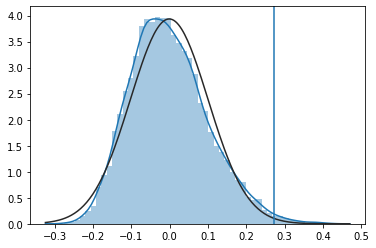

<Figure size 432x288 with 0 Axes>

In [111]:
#plot one of the aligned topic similarity relative to the permuted distribution for that topic. Lets look at the 'construction' topic
from scipy import stats
from scipy.stats import norm

sns.distplot(res[5], fit=norm);
plt.axvline(real[5])
fig = plt.figure()

In [52]:
# Model validation part 2

def get_lda_topics(model, feature_names):
    # the word ids obtained need to be reverse-mapped to the words so we can print the topic names.

    word_dict_lda = {};
    for i in range(no_topics):
        # for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feature_names[key] for key in words_ids]
        word_dict_lda['Topic # ' + '{:02d}'.format(i + 1)] = words;

    return pd.DataFrame(word_dict_lda);

lda_result_df = get_lda_topics(lda_model, X_text_c_feature_names)  

In [90]:
lda_result_df.iloc[:,1]

0      associated
1       authority
2        addition
3            able
4     application
5          better
6          bidder
7         applied
8      capability
9        athletic
10        binding
11        british
12     alteration
13          apply
14         annual
15         behalf
16    accommodate
17             ca
18     additional
19         campus
Name: Topic # 02, dtype: object

In [92]:
# Jaccard similarity is a measure of overlap between a pair of binary variables. Lets see how much overlap there is 
# between the different topics. 1-Jaccard index will tell us how unique each topic cluster is.

def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return float(len(intersection))/float(len(union))

jacc_sims = []
for t1 in range(no_topics):
    topic1=lda_result_df.iloc[:,t1]
    for t2 in range(no_topics):
        topic2=lda_result_df.iloc[:,t2]
        jacc_sims.append(1-jaccard_similarity(topic1,topic2))    

        
print(np.mean(jacc_sims))

0.7941975345830334


In [97]:
# Lets run a model on the full dataset and validate the topics

X_text_c_full = c.fit_transform(df['text'])
lda_model_full = LatentDirichletAllocation(learning_method = 'online', n_components=no_topics, random_state=0).fit(X_text_c_full)
X_text_c_full_feature_names = c.get_feature_names()

# Print out top 20 words from the corpus associated with each topic 
no_top_words = 20
print(display_topics(lda_model_full, X_text_c_full_feature_names, no_top_words))

Topic 0:
school contract program management college county district solution student term public board support process document supplier firm health technology plan
Topic 1:
product furniture table machine digital printing marketing supplier delivery behalf supply instruction classroom alumnus brand energy material category production package
Topic 2:
accessory gas waste conseil soliciting scolaire viamonde acceptable interested disposal board le document laser reference prequalification considered specific shared chemical
Topic 3:
supply delivery communication binding part required purchaser network medium cabling computing wireless mobile install audit switch device department hardware operation
Topic 4:
parking solution purchase issuing lot particular road government study consultant request commercial replace review storage management relocation obtain investment north
Topic 5:
consulting council toronto governing removal environmental college part medical medicine qualification ar

In [101]:
# Just a quick test the model
# the dataset to predict on (first two samples were also in the training set so one can compare)
data_samples = ["Training for case workers on the adverse affects of secondary trauma, vicarious trauma, indirect trauma and compassion fatigue in professionals who work with trauma impacted youth."]
# Vectorize the training set using the model features as vocabulary
tf_vectorizer = CountVectorizer(vocabulary=X_text_c_full_feature_names)
tf = tf_vectorizer.fit_transform(data_samples)

# transform method returns a matrix with one line per document, columns being topics weight
predict = lda_model_full.transform(tf)
print(predict)

[[0.02500673 0.025      0.025      0.025      0.025      0.025
  0.025018   0.025      0.30970534 0.49026993]]


In [102]:
import pyLDAvis.sklearn
print('prepare')
vis_data = pyLDAvis.sklearn.prepare(lda_model_full, X_text_c_full, c, mds='tsne')
print('display')
pyLDAvis.display(vis_data)

prepare


/anaconda3/envs/WildFire/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


display


In [ ]:
# Save off viz for WebApp
pyLDAvis.save_html(vis_data, 'lda.html')

In [32]:
# How do categorical labels map on to topic clusters? 

def classify(model,data):

    # the dataset to predict on (first two samples were also in the training set so one can compare)
    # Vectorize the training set using the model features as vocabulary
    tf_vectorizer = CountVectorizer(vocabulary=X_text_c_feature_names)
    tf = tf_vectorizer.fit_transform(data)

    # transform method returns a matrix with one line per document, columns being topics weight
    predicted = model.transform(tf)
    return predicted

topic_val=pd.DataFrame(columns=['num'])


# Iterate over the column in DataFrame
for idx, entry in  enumerate(df['text']):
    data = [entry]
    class_result=classify(lda_model_full, data)
    # Get the indices of maximum element in numpy array
    topic_number = np.where(class_result == np.amax(class_result))[1][0]
    topic_val.loc[idx,'num']=topic_number


topic_val['categories']=df['UNSPSC Level 2 Description']
by_topic_cat = topic_val.groupby(['num','categories'])['categories'].count()

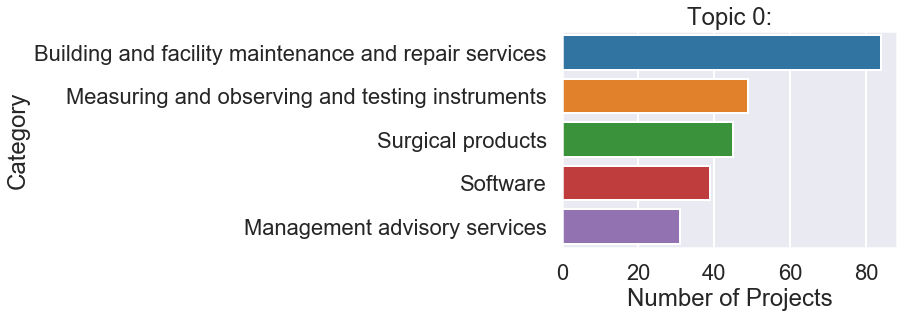

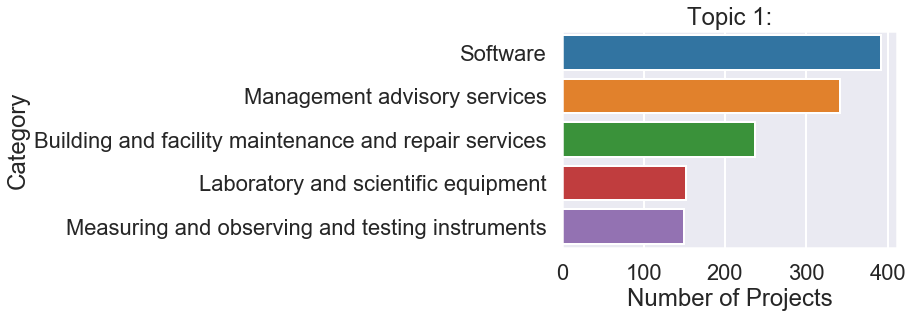

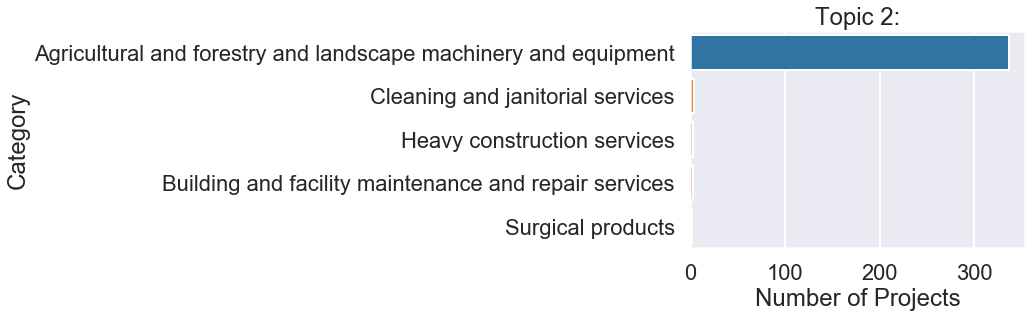

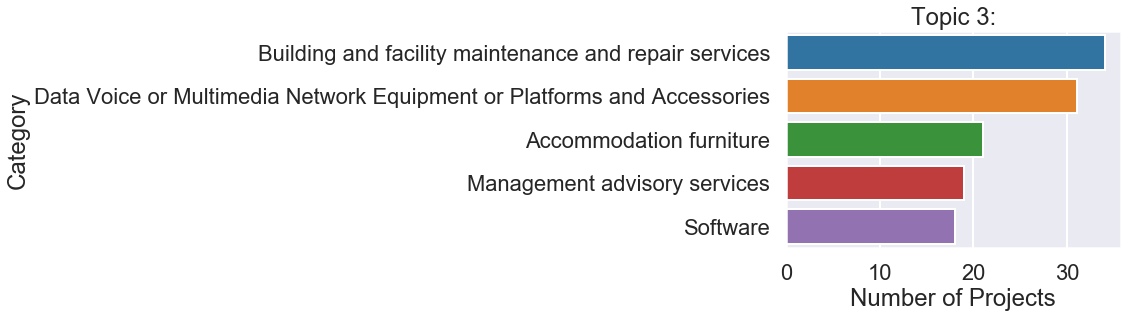

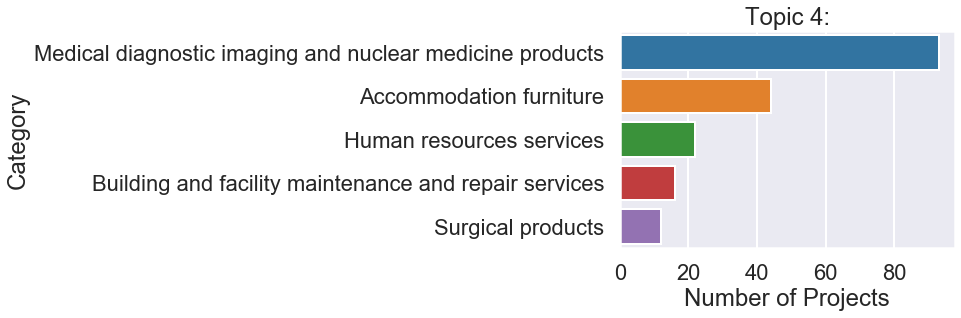

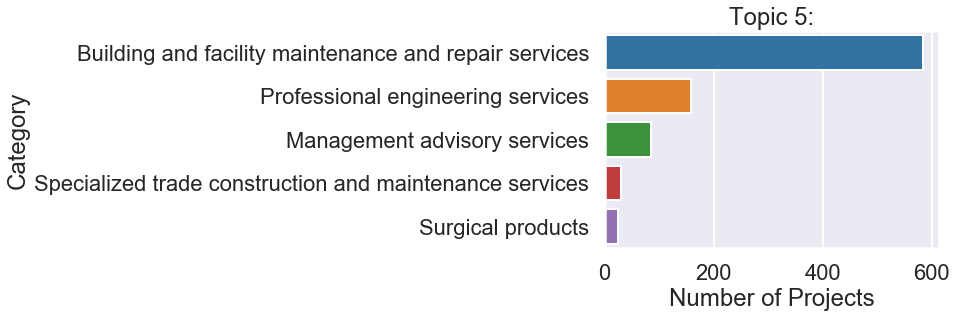

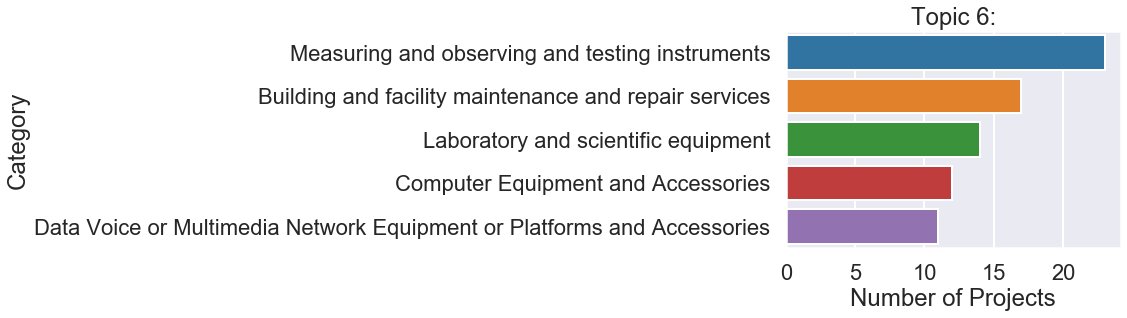

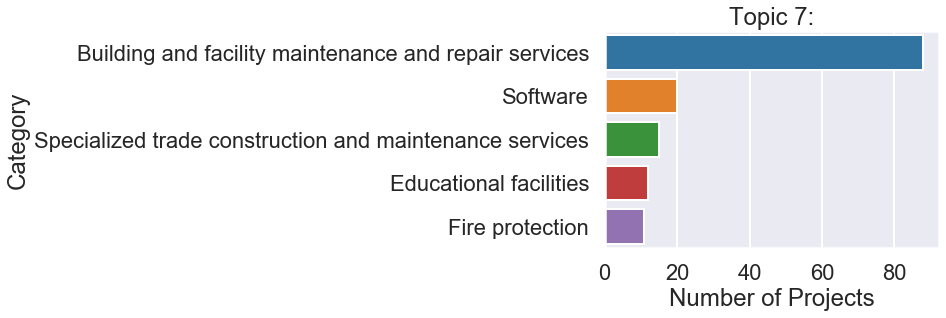

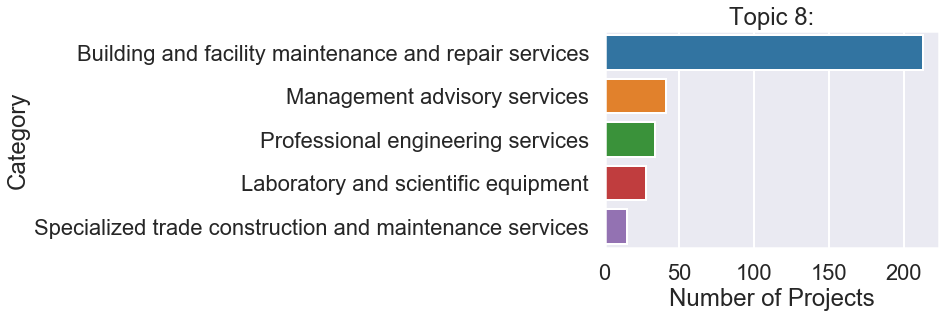

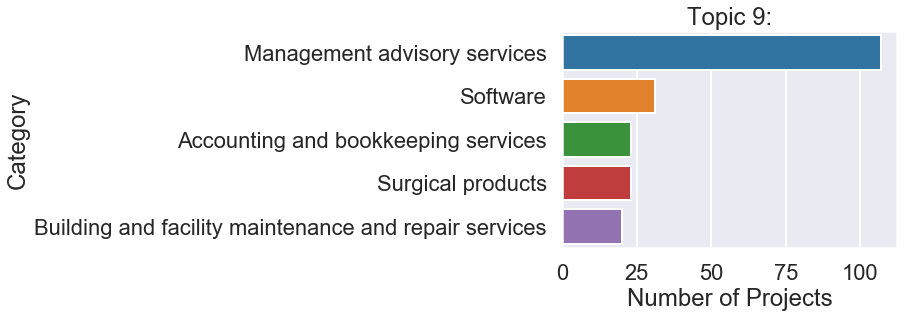

In [197]:
for topic in range(0,no_topics):
    ds=topic_val[topic_val.num==topic]
    sns.set_context("poster")
    with sns.axes_style("darkgrid"):
        sns.countplot(y="categories", data=ds, order=ds.categories.value_counts().iloc[:5].index)
        plt.xlim()
        plt.xlabel('Number of Projects')
        plt.ylabel('Category')
        plt.title("Topic %d:" % (topic))
        plt.show()
        #plt.savefig("fig/Char_Count.png")

In [103]:
# Use cosine similarity to generate recommendations based on project descriptions
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

#Construct a reverse map of indices and movie titles
indices = pd.Series(df.index, index=df['StatementOfWork'])
indices2 = pd.Series(df.index, index=df['UNSPSC Level 2 Description'])

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(X_text_c_full, X_text_c_full)

In [104]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):

    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    proj_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    projects = indices[indices[proj_indices]][:10].index
    labels = indices2[indices2[proj_indices]][:10].index
    recommendations=pd.DataFrame(labels,index=projects)

    return recommendations

get_recommendations('Hand Hygiene Software required for a hospital setting that incorporateds Personal Protective Equipment (PPE)/isolation needs')

,UNSPSC Level 2 Description
StatementOfWork,
Nurition Services Software,Software
RFP 676 Curriculum & Calendar Software,Software
CRM Software Consultancy Services,Human resources services
CRM Software Consultancy Services,Human resources services
Bookstore POS & Payment Tracking Software,Software
Interviewing Software,Software
MODELLING DEVICES - LiDAR Scanners and Software,Telecommunications media services
Transit Specialized Scheduling Software,Software
Scheduling Software,Software


The recommender picks up on projects that have similar labels, but also picks up on projects with different labels ("Human Resource services"). This is important, since a user will be able to see a project and be provided with projects that they normally may not be recommended with the current taxonomy.

In [ ]:
# Save model and related elements for later usage in Web Application.
import pickle
with open('model_lda.pickle', 'wb') as f:
    pickle.dump([lda_model_full,X_text_c_full_feature_names,X_text_c_full,df,indices,cosine_sim], f)
    f.close()